# HOW TO: generate conditional moment equations

This notebook serves the purpose of showing how to generate conditional moment equations from a given reaction network. It shows the steps of 
* defining the reaction network, 
* specifying *selected* and *latent* chemical species, 
* generating the conditional moment equations,
* choosing a moment closure approximation to close the set of generated moment equations, and
* converting the obtained equations to use them for numerical simulations.

For information on theoretical background and manual derivation of conditional moment equations, refer to:

*Duso, L. & Zechner, C. Selected-node stochastic simulation algorithm. J. Chem. Phys. 148, (2018).* (SI)

The automated generation of conditional moment equations is performed using the symbolic mathematics package [sympy](https://www.sympy.org/en/index.html).

In [1]:
from sympy import symbols, Matrix, Function, sympify, init_printing, Array, Pow, Mul, lambdify
from sympy.core.function import AppliedUndef
import string
from operator import mul
from functools import reduce
from itertools import combinations_with_replacement

import dill # saving/restoring files with symbolic expressions
dill.settings['recurse'] = True

init_printing()

from IPython.display import display, Math

In [2]:
import conditionalMomentGenerator as cmg

## 1. Defining the reaction network

Throughout this notebook, we will consider the following reaction system which was treated in *Duso & Zechner (2018)*:

$$\begin{align*}
	\emptyset &\xrightarrow{\;c_1\;} R_i  &G_i^{*} &\xrightarrow{\;c_5\;} G_i^{*} + R_i \\
    R_i &\xrightarrow{\;c_2\;} \emptyset &P_i + G_j^{*} &\xrightarrow{\;c_6\;} P_i + G_j \\
	R_i &\xrightarrow{\;c_3\;} R_i + P_i &G_i &\xrightarrow{\;c_7\;} G_i^{*} \\
	P_i &\xrightarrow{\;c_4\;} \emptyset &G_i^{*} &\xrightarrow{\;c_8\;} G_i \quad\quad\quad\quad\quad\quad i = 1,2\text{,}\;\; j \neq i
\end{align*}$$

with $R_i$: mRNAs, $P_i$: proteins, $G_i^*$/$G_i$: active/inactive promoters.

The network consists of 16 reactions with 8 chemical species and is a model network for symmetric bistable protein expression. Reactions 1 to 5 (9 to 13, respectively) describe the production and degradation of mRNAs and proteins. Reactions 7 and 8 (15 and 16, respectively) describe how the promoters switch from active to inactive state and vice versa at constant rates. In reaction 6 (14, respectively) though, the protein inactivates the promoter of the respective other gene, thereby inhibiting the protein expression of the other protein and indirectly promoting its own expression.

In the conditional moment generator, the reaction network has to be defined in terms of its reactant and product stoichiometry matrices using the `Matrix()` syntax of sympy.

In [3]:
stoich_reac = Matrix(((0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0), # G_1a (active)
                     (0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0), # G_1i (inactive)
                     (0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1), # G_2a
                     (0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0), # G_2i
                     (0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0), # R_1
                     (0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0), # R_2
                     (0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0), # P_1
                     (0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0))) # P_2

stoich_prod = Matrix(((0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0), # G_1a
                     (0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0), # G_1i
                     (0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0), # G_2a
                     (0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1), # G_2i
                     (1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0), # R_1
                     (0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0), # R_2
                     (0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0), # P_1
                     (0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0))) # P_2

species = ['G_1a', 'G_1i', 'G_2a', 'G_2i', 'R_1', 'R_2', 'P_1', 'P_2']

Names for species and reaction rates can be specified by the user. If not specified, default names ($A, B, C$, ... for species and $c_1, c_2, c_3$, ... for rates) are used. The reaction network is initialized by the function `reactionSystem()`.

In [4]:
X, rates, stoich_net = cmg.reactionSystem(stoich_reac, stoich_prod, X = species)

'species:'

'rates:'

'net stoichiometry:'

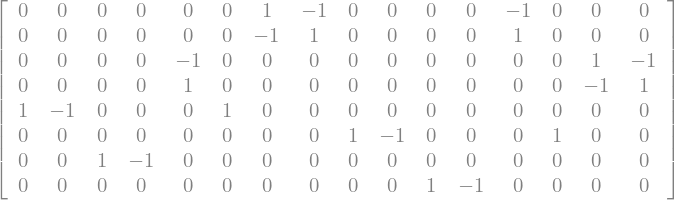

In [5]:
display("species:", X)
display("rates:", rates)
display("net stoichiometry:", stoich_net)

Using `propensities()`, the reaction propensities following mass action kinetics are computed.

In [6]:
display('propensities:', cmg.propensities(X, rates, stoich_reac))

'propensities:'

## 2. Specifying *selected* and *latent* species

Computing conditional moment equations is based on the idea of describing the time course of some chemical species conditioned on the trajectories over time of the remaining chemical species. We term those species for which the whole evolution is given/known explicitly *selected* ($X$), while the other species which we want to generate the conditional moment equations for are termed *latent* ($Z$).

Consequently, the reactions of the network are split into subnetworks which contain:
* reactions that modify latent species only ($R_Z$), 
* reactions that mofidy selected species ($R_X$), and
* coupling reactions where both, selected and latent species are involved ($R_C$).

This is achieved using the command `splitNetwork()` and specifying the names of the *selected* species as a list of strings. For our example, we choose as selected species the active and inactive promoters $X = (G_1^*,G_1,G_2^*,G_2)$.

In [7]:
select = ['G_1a', 'G_1i', 'G_2a', 'G_2i']
idx_select, idx_latent, RX, RL, RO, RH, RC, RZ = cmg.splitNetwork(select, X, stoich_net, stoich_reac, stoich_prod)

In [8]:
display("selected species:", [X[i] for i in idx_select])
display("latent species:", [X[i] for i in idx_latent])
display("latent reactions:", [i+1 for i in RZ])
display("selected reactions:", [i+1 for i in RX])
display("coupling reactions:", [i+1 for i in RC])

'selected species:'

'latent species:'

'latent reactions:'

'selected reactions:'

[5, 7, 8, 13, 15, 16]

'coupling reactions:'

[5, 13]

## 3. Generating the filter equation

Before generating the conditional moment equations for the latent species, the filter equation needs to be set up. The filter equation $\pi(z,t) = p(z,t | \textbf{X}_t)$ is a differential equation for the conditional probability distribution of the latent chemical species given the histories of the selected species. Similar to the chemical master equation, it contains deterministic terms with stoichiometric changes towards and away from the current state of the latent species, but additionally, it contains stochastic terms for each of the coupling reactions, i.e., those reactions that involve both, selected and latent species. In the generator tool, the filter equation is generated via the command `computeFilterEquation()`.

In [9]:
filterEqT, filterEqR = cmg.computeFilterEquation(X, rates, stoich_reac, 
                                                 stoich_net, RO, RL, RZ, idx_latent, idx_select)
filterEq = filterEqT + filterEqR

'Filter equation:'

<IPython.core.display.Math object>

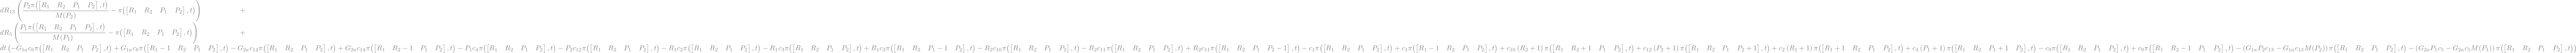

In [10]:
display("Filter equation:")
display(Math(r'd \pi({}, t) = '.format([X[i] for i in idx_latent])))
display(filterEq)
#display("Time-dependent part:", filterEqT)
#display("Stochastic part:", filterEqR)

In the tool, we use the notation $M()$ for moments (e.g., $M(P_1^2)$ is the second moment of species $P_1$).

Note that the *selected* species occur explicitly in the expression while the *latent* species only occur in terms of moments.

## 4. Generating the conditional moment equations

Given the filter equation, conditional moment equations up to a specified `order` can be generated using `generateConditionalMomentEquations()`.

In [11]:
order = 2
dM, conditional_moments = cmg.generateConditionalMomentEquations(X, idx_latent, filterEq, order=order)

'Moments for which the conditional moment equations are generated:'

'Example of a conditional moment equation:'

<IPython.core.display.Math object>

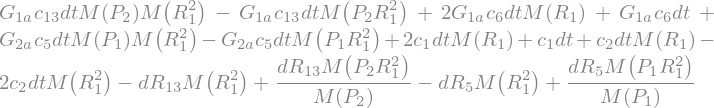

In [12]:
display("Moments for which the conditional moment equations are generated:", dM)
display("Example of a conditional moment equation:")
display(Math(r'dM( {} ) = '.format(dM[4])))
display(conditional_moments[dM[4]])

## 5. Closing the set of moment equations

Conditional moment equations of a certain order generally depend on higher order moments such that the system of differential equations is not closed. In the above example, the exemplary equation for a second order moment also depends on third order moments.

One way to address this issue is to use a moment closure approximation. Background information on the different assumptions and mechanisms behind moment closure approximations can be found in the literature, e.g. *Schnoerr, D., Sanguinetti, G. & Grima, R. Comparison of different moment-closure approximations for stochastic chemical kinetics. J. Chem. Phys. 143, (2015).*

Available moment closure schemes in the generator tool are `normal` and `lognormal` closures for 2nd and 3rd order, i.e., moments of 3rd and 4th order are approximated as functions of lower order terms. The previously computed set of raw conditional moment equations can be closed using the command `closeMoments()`.

In [13]:
closed_moments = cmg.closeMoments(conditional_moments, scheme = "normal", order = order)

Example of a closed moment equation:


<IPython.core.display.Math object>

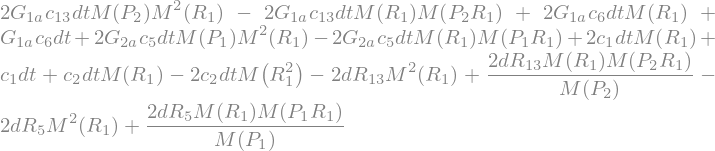

In [14]:
print("Example of a closed moment equation:")
display(Math(r'dM( {} ) = '.format(dM[4])))
display(closed_moments[dM[4]])

Note that the expression now only contains moments up to the specified order 2.

## 6. Converting the obtained equations for further use

The obtained set of closed conditional moment equations now can be further used for a variety of applications. In order to perform simulations or use them in another way, the symbolic expressions can be converted into numerically evaluable functions using `sympy`'s function `lambdify`. In the generator, the `sympyExprToDiffEq()` command provides a mean to separate the deterministic and stochastic parts of the expressions which then can be lamdified separately.

In [15]:
det, mapping, stoch = cmg.sympyExprToDiffEq(dM, closed_moments, stoich_net)
moment_names = [m for _,m in mapping]

In [16]:
det_func = lambdify([symbols('y'), symbols('t'), X, rates, moment_names], det)
stoch_func = lambdify([X, rates, moment_names], stoch)

`det_func` is a function for the deterministic (time-dependent) parts of the differential moment equations.

`stoch_func` is a function for the stochastic jumps that contribute to the differential equations if a coupling reaction fires.

## 7. Wrapping everything together

Alternatively, all of the above steps of generating the conditional moment equations can be combined in one single command: `generateEquations()`.

It requires as input the reactant and product stoichiometry, and a list of *selected* species. Optional inputs are species and rate names (default: $A,B,C, ..., c_1, c_2, c_3, ...$) , the order up to which the moment equations should be generated (default: 2), and a closure scheme (`normal` or `lognormal`; default: `normal`).
If a name for an output `file` is given, the output will be saved to a `txt` file and to a dill file which saves the symbolic expressions such that they can be read into Python and do not need to be computed again.

The output is a dictionary which contains the species, rates, propensities, net stoichiomentry, names of moments for which conditional moment equations were generated, raw moment equations, closed moment equations, as well as their deterministic and stochastic parts.

In [17]:
stoich_reac = Matrix(((0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0), # G_1a (active)
                     (0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0), # G_1i (inactive)
                     (0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1), # G_2a
                     (0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0), # G_2i
                     (0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0), # R_1
                     (0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0), # R_2
                     (0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0), # P_1
                     (0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0))) # P_2

stoich_prod = Matrix(((0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0), # G_1a
                     (0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0), # G_1i
                     (0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0), # G_2a
                     (0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1), # G_2i
                     (1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0), # R_1
                     (0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0), # R_2
                     (0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0), # P_1
                     (0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0))) # P_2

species = ['G_1a', 'G_1i', 'G_2a', 'G_2i', 'R_1', 'R_2', 'P_1', 'P_2'] # optional
select = ['G_1a', 'G_1i', 'G_2a', 'G_2i']
order = 2 # optional
scheme = 'normal' # optional
file = 'example_output'

In [18]:
my_system = cmg.generateEquations(stoich_reac, 
                                  stoich_prod,
                                  X = species,
                                  #rates = constants, # (optional list with names for reaction rate constants)
                                  select = select, 
                                  order = order, 
                                  scheme = scheme, 
                              file = file)

In [19]:
print("The generated dictionary contains:", my_system.keys())

The generated dictionary contains: dict_keys(['species', 'rates', 'stoich_net', 'stoich_reac', 'stoich_prod', 'propensities', 'idx_select', 'idx_latent', 'RX', 'RL', 'RO', 'RH', 'RC', 'RZ', 'filterEq', 'dM', 'conditional_moments', 'closed_moments', 'det_parts', 'stoch_parts', 'mapping'])


To further use the obtained equations in numerical applications, symbolic expressions of the reaction network can be restored from the output file using the command `loadAndLamdify()`. This command also generates numerically evaluable functions for the deterministic and stochastic parts of the conditional moment equations.

In [20]:
my_system_loaded, det_func, stoch_func = cmg.loadAndLambdify(file)

## 8. Further remarks

To see a potential **application** of the conditional moment equations, check out the `snSSA` notebook.

If you only want to generate the **chemical master equation** of a reaction network, do the following:
1. specify the reactant and product stoichiometry as shown above using the `Matrix()` syntax
2. execute `X, rates, stoich_net = reactionSystem(stoich_reac, stoich_prod)`
2. execute `idx_select, idx_latent, RX, RL, RO, RH, RC, RZ = splitNetwork(select, X, stoich_net, stoich_reac, stoich_prod)`
3. execute `CME = chemicalMasterEquation(X, rates, stoich_reac, stoich_net, RZ, idx_latent, idx_select)`

If you need **further information** on the implemented functions, you can access their docstrings via `?<function>`:

In [21]:
?cmg.reactionSystem

Signature: cmg.reactionSystem(stoich_reac, stoich_prod, X=None, rates=None)
Docstring:
Generates symbolic species and rate names, as well as net stoichiometry
of the reaction system.
If names for rates and species are not specified, default names are used.

Example:
    species names for 2 occurring species: X = ['G_on', 'G_off']
    rate names for 4 reactions: rates = ['prod', 'prod_2', 'degr', 'conv']

Parameters
----------
stoich_reac : sympy.Matrix()
    reaction stoichiometry of the reaction system.
stoich_prod : sympy.Matrix()
    product stoichiometry of the reaction system.
X : list of strings, optional
    specified names of species. 
    The default is None.
rates : list of strings, optional
    specified names of chemical reaction rates. 
    The default is None.

Returns
-------
X : list of symbols
    symbolic species names.
rates : list of symbols
    symbolic rate names.
stoich_net : sympy.Matrix()
    net stoichiometry matrix of reaction system.
File:      ~/Documents/C